<a href="https://colab.research.google.com/github/YapingWu/GoogleColab/blob/main/genpass/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

分析数据集大小和数据分布

# 原始密码分析

## 上传数据集

In [ ]:
!unzip '/content/raw_data.zip'

Archive:  /content/raw_data.zip
  inflating: phpbb.txt               
  inflating: rockyou.txt             
  inflating: myspace.txt             


## 统计数据集大小

In [ ]:
import pandas as pd

names = ['myspace', 'phpbb', 'rockyou']
data_list = []
for name in names:
  data = pd.read_csv('/content/{}.txt'.format(name), header=None, names=['pwd'])
  data['name'] = name
  data_list.append(data)
  print('{}：{}'.format(name, data.shape))
  # print(data.head(5)

In [ ]:
raw_data = pd.concat(data_list)  # 合并dataframe
print(raw_data.shape)  # (14560896, 2)

# 计算数据集中密码长度
raw_data['len'] = raw_data['pwd'].apply(lambda x: len(str(x)))
# print(raw_data.head(5))

(14560896, 2)


## 分析数据集数据分布

### 分析密码长度分布

In [ ]:
# 计算不同密码长度的密码个数
raw_data_size = raw_data.groupby(['name', 'len']).size().rename('size').reset_index()
# print(raw_data_size.head(5))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def draw():
  fig, axs = plt.subplots(1, 3, figsize=(12, 4))

  x, y = {}, {}
  for index, name in enumerate(names):
    x[name] = raw_data_size.loc[raw_data_size['name'] == name, ['len']]
    y[name] = raw_data_size.loc[raw_data_size['name'] == name, ['size']]
    axs[index].plot(x[name], y[name])
    axs[index].set_title(name)
    axs[index].set_xlabel('length')
    axs[index].set_ylabel('size')

  fig.tight_layout()
  plt.show()


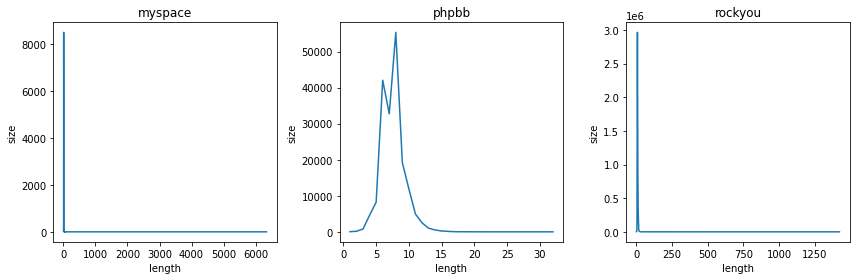

In [ ]:
draw()

图中可以看出，myspace和rockyou中有很多异常值（有些密码有几千个字符）。

接下来过滤掉异常值，再分析。

In [ ]:
# 过滤异常值
print('长度个数大于50的密码：%d' % len(raw_data[raw_data['len'] > 50]))  # 1183
raw_data = raw_data[raw_data['len'] <= 50]
print(raw_data.shape)  # (14559713, 3)

# 计算不同密码长度的密码个数
raw_data_size = raw_data.groupby(['name', 'len']).size().rename('size').reset_index()
# print(raw_data_size.head(5))

长度个数大于50的密码：1183
(14559713, 3)


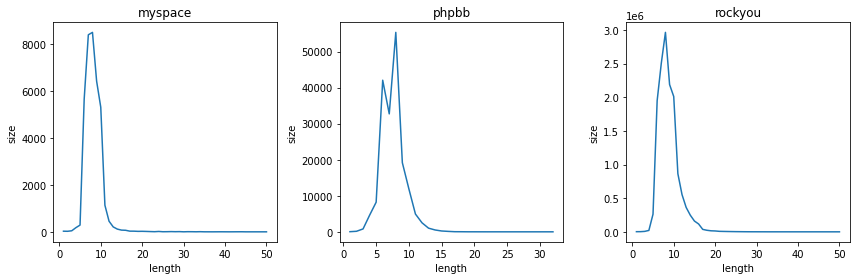

In [ ]:
draw()

分析结果可看出，大部分密码长度在（5，20）区间。

# PCFG编码后的密码分析
1. 上传编码后的密码文件：`myspace.txt` `phpbb.txt`

In [1]:
!unzip '/content/wordlist.zip' -d './wordlist/'

Archive:  /content/wordlist.zip
  inflating: ./wordlist/phpbb.txt    
  inflating: ./wordlist/myspace.txt  


In [3]:
import pandas as pd

data_list = []
for name in ['myspace', 'phpbb']:
    df = pd.read_csv('./wordlist/{}.txt'.format(name))
    df['grammar'] = df['grammar'].apply(lambda x: str(x).strip())
    df['len'] = df['grammar'].apply(lambda x: len(x.split(' ')))
    df['name'] = name
    data_list.append(df)

data = pd.concat(data_list)

## 数据集大小（样本数量）

In [4]:
size_df = data.groupby('name').size().rename('size').reset_index()
print(size_df)

      name  size
0  myspace  1702
1    phpbb  2913


## 序列长度分析

In [5]:
len_df = data.groupby('name').agg({'len': 'max'}).reset_index()
print(len_df)

      name  len
0  myspace   18
1    phpbb   20


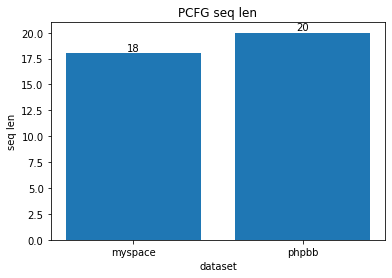

In [6]:
import matplotlib.pyplot as plt

x, y = len_df['name'], len_df['len']

fig, axs = plt.subplots()
axs.bar(x, y)
axs.set_title('PCFG seq len')
axs.set_xlabel('dataset')
axs.set_ylabel('seq len')

for a,b in zip(x,y):
  plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom')

## 序列长度分布分析

In [7]:
data_size = data.groupby(['name', 'len']).size().rename('size').reset_index()
print(data_size.head(5))

      name  len  size
0  myspace    1    55
1  myspace    2   238
2  myspace    3   532
3  myspace    4   375
4  myspace    5   237


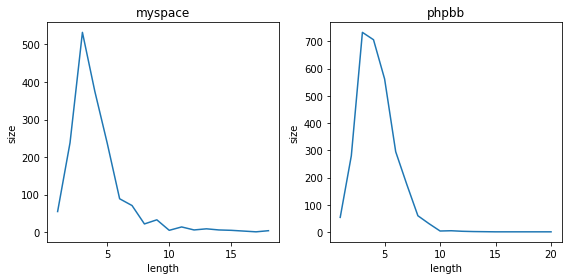

In [9]:
names = ['myspace', 'phpbb']
def draw():
  fig, axs = plt.subplots(1, 2, figsize=(8, 4))

  x, y = {}, {}
  for index, name in enumerate(names):
    x[name] = data_size.loc[data_size['name'] == name, ['len']]
    y[name] = data_size.loc[data_size['name'] == name, ['size']]
    axs[index].plot(x[name], y[name])
    axs[index].set_title(name)
    axs[index].set_xlabel('length')
    axs[index].set_ylabel('size')

  fig.tight_layout()
  plt.show()

draw()

## 序列单元数量分析

In [10]:
!unzip '/content/freq_password.zip' -d './freq_password/'

Archive:  /content/freq_password.zip
  inflating: ./freq_password/phpbb.txt  
  inflating: ./freq_password/myspace.txt  


In [11]:
import pandas as pd

data_list = []
for name in ['myspace', 'phpbb']:
    df = pd.read_csv('./freq_password/{}.txt'.format(name))
    df['name'] = name
    data_list.append(df)

data = pd.concat(data_list)
print(data.head(5))

  unit   password  pwd_cnt_per_unit  pwd_prop     name
0   S9  @@###$$$$               1.0      1.00  myspace
1   S8   !@#$%^&*               1.0      1.00  myspace
2   S6     ......               3.0      0.75  myspace
3   S6     @@@!!!               1.0      0.25  myspace
4   S5      !!!!!               3.0      0.30  myspace


In [12]:
# 计算每个单元出现的个数
unit_size = data.groupby(['name', 'unit']).size().rename('size').reset_index()
print(unit_size.head(5))

      name   unit  size
0  myspace  <END>     1
1  myspace     D1    10
2  myspace    D10    22
3  myspace    D11     4
4  myspace    D12     2


In [16]:
# 按个数降序排序
unit_size.sort_values(['name', 'size'], inplace=True, ascending=False, ignore_index=True)

print(unit_size.head(5))

    name unit   size
0  phpbb   L6  26724
1  phpbb   L8  21665
2  phpbb   L7  19843
3  phpbb   L5  13464
4  phpbb   L4  11006


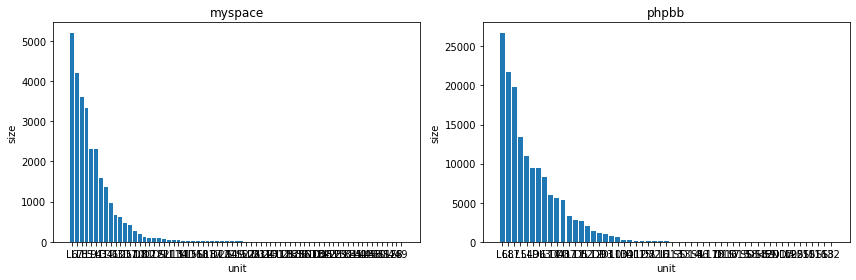

In [28]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

x, y = {}, {}
for index, name in enumerate(names):
  x[name] = unit_size.loc[unit_size['name'] == name, 'unit']
  y[name] = unit_size.loc[unit_size['name'] == name, 'size']
  axs[index].bar(x[name], y[name])
  axs[index].set_title(name)
  axs[index].set_xlabel('unit')
  axs[index].set_ylabel('size')

fig.tight_layout()
plt.show()